# Calculate the Wasserstein distance for showerflow models


In [1]:
import os
import numpy as np
import torch
from pointcloud.config_varients import caloclouds_3_simple_shower
from pointcloud.evaluation import discriminator
from pointcloud.utils import showerflow_training, showerflow_utils
from pointcloud.utils.metadata import Metadata
from pointcloud.utils.plotting import RatioPlots, nice_hex
from matplotlib import pyplot as plt


config = caloclouds_3_simple_shower.Configs()
if torch.cuda.is_available():
    config.device = "cuda"
else:
    config.device = "cpu"
if os.path.exists(os.path.dirname(config.dataset_path)):
    print(f"Found dataset at {config.dataset_path}")
    

Found dataset at /data/dust/user/akorol/data/AngularShowers_RegularDetector/hdf5_for_CC/sim-E1261AT600AP180-180_file_{}slcio.hdf5


Get the generator models we will be comparing with, and check their data has been generated.

In [2]:
discriminator.create_g4_data_files(config)

All g4 data files already exist


In [3]:
existing_list = []
for weight_decay in [0., 0.0001, 0.1]:
    config.shower_flow_weight_decay = weight_decay
    for dhist in [True, False]:
        config.shower_flow_detailed_history = dhist
        for fnorm in [True, False]:
            config.shower_flow_fixed_input_norms = fnorm
            for tbase in [True, False]:
                config.shower_flow_train_base = tbase
                found_here = showerflow_utils.existing_models(config)
                existing_list.append(showerflow_utils.existing_models(config))
existing_models = {
    key: sum([model[key] for model in existing_list], []) for key in existing_list[0]
}
existing_models["config"] = []

for i, path in enumerate(existing_models["paths"]):
    model_config = showerflow_utils.construct_config(config, existing_models, i)
    try:
        discriminator.create_showerflow_data_files(model_config, path)
    except Exception:
        print(path)
    existing_models["config"].append(model_config)

print(f"Total models found: {len(existing_models['names'])}")
        

Found 0 saved models
Found 0 saved models
Found 3 saved models
Found 3 saved models
Found 0 saved models
Found 0 saved models
Found 3 saved models
Found 3 saved models
alt1_nb4_fnorms_tbase_wo[0, 1, 4] has best loss -148.28390316087373
Found 3 saved models
alt1_nb4_fnorms_tbase_wo[0, 1, 4] has best loss -148.28390316087373
Found 3 saved models
original_nb4_fnorms_wo[0, 1, 4] has best loss -145.9351401815609
alt1_nb4_fnorms_wo[0, 1, 4] has best loss -147.62754416952328
Found 10 saved models
original_nb4_fnorms_wo[0, 1, 4] has best loss -145.9351401815609
alt1_nb4_fnorms_wo[0, 1, 4] has best loss -147.62754416952328
Found 10 saved models
Found 0 saved models
Found 0 saved models
Found 1 saved models
Found 1 saved models
Found 0 saved models
Found 0 saved models
Found 3 saved models
Found 3 saved models
Found 0 saved models
Found 0 saved models
Found 3 saved models
Found 3 saved models
Found 0 saved models
Found 0 saved models
Found 0 saved models
Found 0 saved models
Found 0 saved models

In [4]:

#table = [['', 'versions', 'num_blocks', 'cut_inputs', 'fixed_input_norms', 'train_base', 'best_loss']]
table = [['', 'versions', 'num_blocks', 'cut_inputs', 'fixed_input_norms', 'best_loss', 'weight_decay']]
col_width = 15
n_models = len(existing_models['paths'])
for i in range(n_models):
    table.append([str(i)] + [str(existing_models[k][i]) for k in table[0][1:]])
for row in table:
    line = ""
    for col in row:
        col = col[:col_width]
        col = " "*(col_width-len(col)) + col
        col += ","
        line += col
    print(line)
    

               ,       versions,     num_blocks,     cut_inputs,fixed_input_nor,      best_loss,   weight_decay,
              0,       original,             10,            014,           True,            inf,            0.0,
              1,           alt1,              2,            014,           True,            inf,            0.0,
              2,           alt1,             10,            014,           True,            inf,            0.0,
              3,       original,             10,               ,          False,            inf,            0.0,
              4,           alt1,              2,               ,          False,            inf,            0.0,
              5,           alt1,             10,               ,          False,            inf,            0.0,
              6,           alt1,              1,            014,           True,-150.2692550347,            0.0,
              7,           alt1,              2,            014,           True,-149.0462070387,

In [5]:
existing_models.keys()

dict_keys(['versions', 'names', 'num_blocks', 'cut_inputs', 'best_loss', 'paths', 'cond_features', 'weight_decay', 'fixed_input_norms', 'config'])

## data fetching

The same libraries as were used to train the discriminator make it easy to get Wasserstein distances.

In [6]:
g4_data_folder = discriminator.locate_g4_data(config)
print(f"g4 data in {g4_data_folder}")
def gen_training(model_idx, settings="settings12"):
    model_name = existing_models["names"][model_idx]
    model_config = existing_models["config"][model_idx]
    model_path = existing_models["paths"][model_idx]
    model_data_folder = discriminator.locate_model_data(model_config, model_path)
    feature_mask = discriminator.feature_masks[settings]
    if not os.path.exists(g4_data_folder):
        os.makedirs(g4_data_folder)
    if not os.path.exists(model_data_folder):
        os.makedirs(model_data_folder)
    training = discriminator.Training(settings, g4_data_folder, model_data_folder, discriminator.descriminator_params[settings], feature_mask)
    return model_name, training

first_model, training = gen_training(0)
idxs = [2, 6, 19]
print(first_model)


g4_test = training._test_dataset.g4_features
gen_test = training._test_dataset.generator_features

# input dimensions
cogs = [0, 1, 2]
if training.state_dict["feature_mask"] is not None:
    cogs = np.where(training.state_dict["feature_mask"][:3])[0].tolist()

n_cogs = len(cogs)
n_pnts_layers = 30
if training.state_dict["feature_mask"] is not None:
    n_pnts_layers = np.sum(training.state_dict["feature_mask"][3:33])
    
n_es_layers = 30
if training.state_dict["feature_mask"] is not None:
    n_es_layers = np.sum(training.state_dict["feature_mask"][33:])

g4 data in /data/dust/user/dayhallh/point-cloud-diffusion-logs/sim-E1261AT600AP180-180/discriminator/g4
original_nb10_fnorms_dhist_wo[0, 1, 4]


In [7]:
from scipy.stats import wasserstein_distance
save_name = os.path.join(showerflow_utils.get_showerflow_dir(config), "wasserstein.npz")
if os.path.exists(save_name):
    redo = False
    loaded = np.load(save_name)
    distances_1d = list(loaded["Wasserstein_distances"])
else:
    redo = True
    distances_1d = [np.zeros(n_cogs+n_pnts_layers+n_es_layers) for _ in existing_models["paths"]]

In [8]:

total_ticks = n_cogs*n_models
if cogs and redo:
    for ci, c in enumerate(cogs):
        truth = g4_test[:].T[ci]
        for i in range(n_models):
            percent = (ci*n_models+i)/total_ticks
            print(f"{percent:.1%}", end="\r")
            name, training = gen_training(i)
            gen_test = training._test_dataset.generator_features
            try:
                gen_data = gen_test[:].T[ci]
                distance = wasserstein_distance(truth, gen_data)
                distances_1d[i][ci] = distance
            except Exception:
                pass

In [9]:
total_ticks = n_pnts_layers*n_models
if n_pnts_layers and redo:
    for pi, p in enumerate(range(n_cogs, n_cogs+n_pnts_layers)):
        truth = g4_test[:].T[pi]
        for i in range(n_models):
            percent = (pi*n_models+i)/total_ticks
            print(f"{percent:.1%}", end="\r")
            name, training = gen_training(i)
            gen_test = training._test_dataset.generator_features
            try:
                gen_data = gen_test[:].T[pi]
                distance = wasserstein_distance(truth, gen_data)
                distances_1d[i][pi+n_cogs] = distance
            except Exception:
                pass

In [10]:
total_ticks = n_es_layers*n_models
if n_es_layers and redo:
    for ei, e in enumerate(range(n_cogs+n_pnts_layers, n_cogs+n_pnts_layers+n_es_layers)):
        truth = g4_test[:].T[e]
        for i in range(n_models):
            percent = (ei*n_models+i)/total_ticks
            print(f"{percent:.1%}", end="\r")
            name, training = gen_training(i)
            gen_test = training._test_dataset.generator_features
            try:
                gen_data = gen_test[:].T[ei]
                distance = wasserstein_distance(truth, gen_data)
                distances_1d[i][ei] = distance
            except Exception:
                pass

In [11]:
if redo:
    existing_models["Wasserstein_distances"] = distances_1d
    np.savez(save_name, **existing_models)
    redo = False

In [12]:
print(existing_models.keys())
save_name = os.path.join(showerflow_utils.get_showerflow_dir(config), "sliced_wasserstein.npz")
working = [i for i in range(len(existing_models["names"])) if distances_1d[i][0] > 0]
n_working = len(working)
if os.path.exists(save_name):
    loaded = np.load(save_name)
    distances = loaded["sliced_wasserstein_distances"]
else:
    import ot
    
    g4_test = training._test_dataset.g4_features
    n_events = 10000
    truth_data = g4_test[:n_events]
    n_projections = 1000
    n_seeds = 10
    distances = np.empty((n_working, n_seeds))
    for i, w in enumerate(working):
        print(f"{i/n_working:.1%}", end="\r")
        try:
            name, training = gen_training(w)
        except Exception as e:
            print()
            print(e)
            print()
            
        gen_test = training._test_dataset.generator_features
        gen_data = gen_test[:n_events]
        for seed in range(n_seeds):
            distances[i, seed] = ot.sliced_wasserstein_distance(truth_data, gen_data, n_projections=n_projections, seed=seed)

    existing_models["sliced_wasserstein_distances"] = distances
    np.savez(save_name, **existing_models)

dict_keys(['versions', 'names', 'num_blocks', 'cut_inputs', 'best_loss', 'paths', 'cond_features', 'weight_decay', 'fixed_input_norms', 'config', 'Wasserstein_distances'])


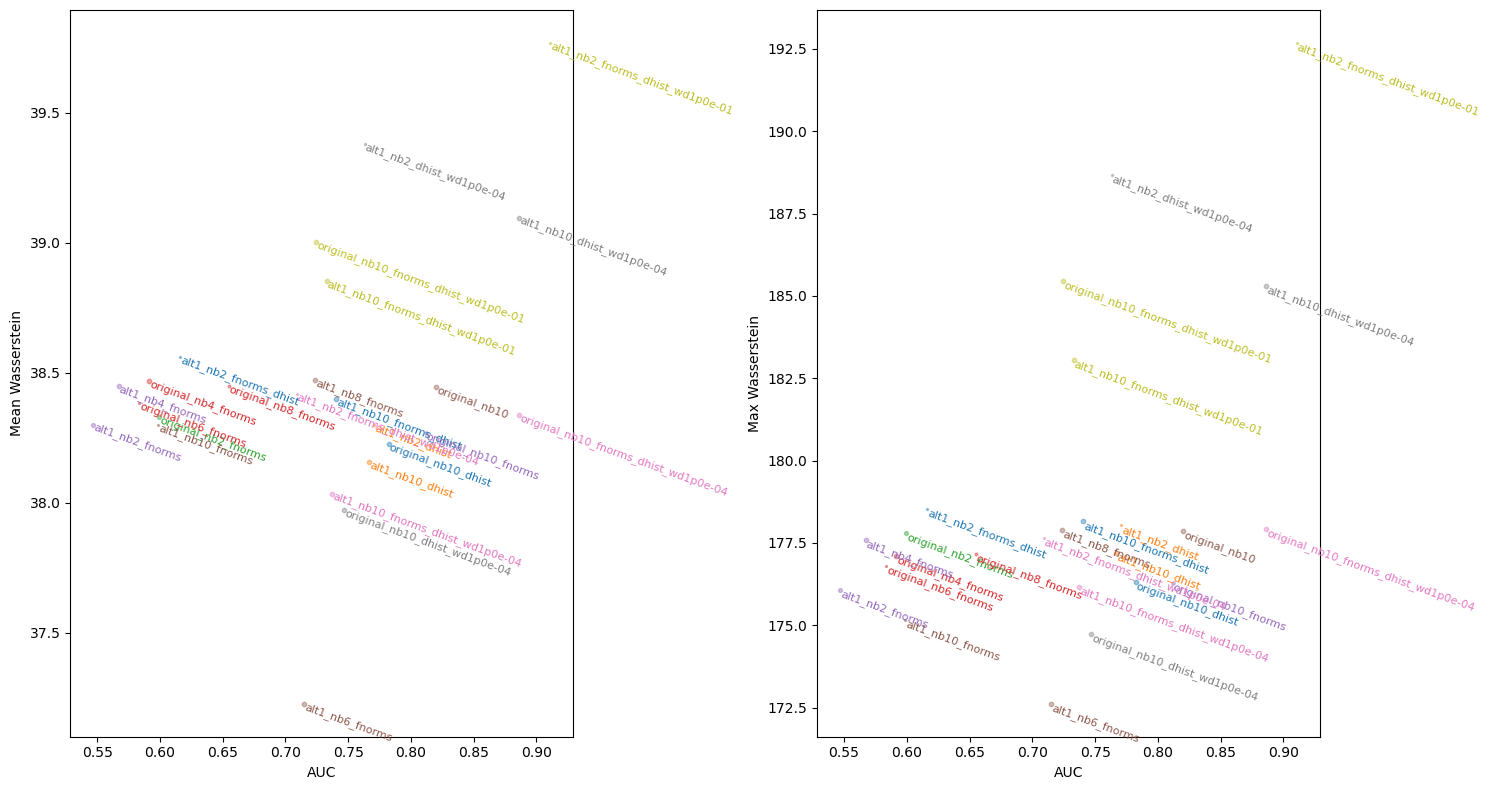

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
cmap = plt.cm.tab10
heights = np.linspace(np.min(distances), np.max(distances), n_working)
from sklearn import metrics
n_models = len(existing_models["names"])

try:
    assert len(aucs) == n_models
except Exception:
    path = os.path.join(g4_data_folder, "../summary.npz")
    if os.path.exists(path):
        from_summary = np.load(path)
        summary_paths = [str(p) for p in from_summary['paths']]
    else:
        summary_paths = []
    aucs = []
    print(f"Have summary_paths {summary_paths}")
    for i in range(n_models):
        print(f"{i/n_models}", end="\r")
        this_path = existing_models['paths'][i]
        if this_path in summary_paths:
            idx = summary_paths.index(this_path)
            auc = from_summary['auc'][idx]
        elif "tbase" in this_path:
            auc = None
        else:
            name, training = gen_training(i)
            training.chatty = True
            try:
                training.reload()
            except Exception:
                auc = None
            else:
                labels, predictions = training.predict_test()
                auc = metrics.roc_auc_score(labels, predictions)
        aucs.append(auc)

for i, w in enumerate(working):
    print(f"{i/n_models}", end="\r")
    name = existing_models["names"][i].split("_wo")[0]
    if name == "original_nb10_fnorms_dhist":
        continue
    distance = np.mean(distances[i])
    distance_err = np.std(distances[i])              
    auc = aucs[i]
    if auc is None:
        continue
    c = cmap(i/n_models)
    mean_distance = np.mean(distances_1d[w])
    max_distance = np.max(distances_1d[w])
    ax1.text(auc, mean_distance-0.02, name,
             rotation=-20, rotation_mode='anchor',
             color=c, size=8
            )
    n_blocks = existing_models["num_blocks"][w]
    ax1.scatter([auc,], [mean_distance,], s=n_blocks, alpha=0.4,
             c=c)
    ax2.text(auc, max_distance-0.2, name,
             rotation=-20, rotation_mode='anchor',
             color=c, size=8
            )
    ax2.scatter([auc,], [max_distance,], s=n_blocks, alpha=0.4,
             c=c)

ax1.set_ylabel("Mean Wasserstein")
ax1.set_xlabel("AUC")
ax2.set_ylabel("Max Wasserstein")
ax2.set_xlabel("AUC")
fig.tight_layout()
plt.savefig("wasserstein_1d_vs_auc.png")

# Plot and compare....

TODO....

In [15]:
match_on = ['versions', 'num_blocks', 'fixed_input_norms'] #, 'train_base']


groupings = []
for key in match_on:
    group_vars = list(set(existing_models[key]))
    group = []
    for g in group_vars:
        here = [i for i, found in enumerate(existing_models[key]) if found == g]
        if len(here)>4:
            here = [i for i in here if existing_models["num_blocks"][i]<6]
        group.append(here)
    groupings.append((group_vars, group))

In [16]:

import ot

first_model, training = gen_training(5)
print(first_model)

g4_test = training._test_dataset.g4_features
gen_test = training._test_dataset.generator_features

n_events = 10000
truth_data = g4_test[:n_events]
gen_data = gen_test[:n_events]

n_seed = 10
n_projections_arr = np.logspace(0, 3, 10, dtype=int)
res = np.empty((n_seed, 10))

for seed in range(n_seed):
    print(f"seed = {seed}")
    for i, n_projections in enumerate(n_projections_arr):
        print(f"{i/10:.1%}", end="\r")
        res[seed, i] = ot.sliced_wasserstein_distance(truth_data, gen_data, n_projections=n_projections, seed=seed)
    print()

res_mean = np.mean(res, axis=0)
res_std = np.std(res, axis=0)


alt1_nb10_dhist
seed = 0
90.0%
seed = 1
90.0%
seed = 2
90.0%
seed = 3
90.0%
seed = 4
90.0%
seed = 5
90.0%
seed = 6
90.0%
seed = 7
90.0%
seed = 8
90.0%
seed = 9
90.0%


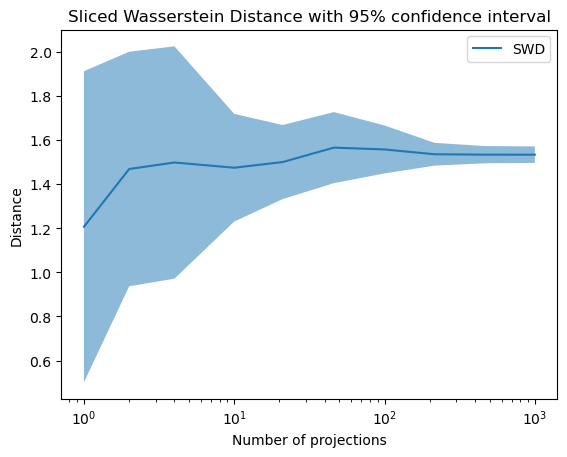

In [17]:
from matplotlib import pyplot as plt
plt.figure(2)
plt.plot(n_projections_arr, res_mean, label="SWD")
plt.fill_between(n_projections_arr, res_mean - 2 * res_std, res_mean + 2 * res_std, alpha=0.5)
plt.legend()
plt.xscale('log')
plt.xlabel("Number of projections")
plt.ylabel("Distance")
plt.title('Sliced Wasserstein Distance with 95% confidence interval')
plt.show()


In [32]:
len(working)

29

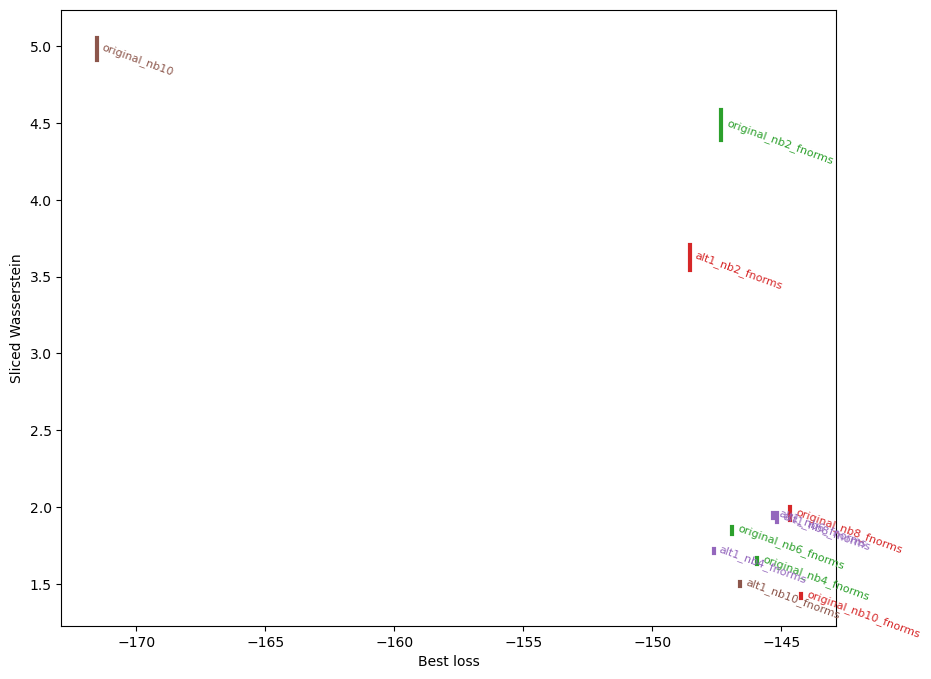

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.cm.tab10
heights = np.linspace(np.min(distances), np.max(distances), n_working)

for i, w in enumerate(working):
    name = existing_models["names"][w].split("_wo")[0]
    if name == "original_nb10_fnorms_dhist":
        continue
    distance = np.mean(distances[i])
    distance_err = np.std(distances[i])
    loss = existing_models["best_loss"][w]
    c = cmap(i/n_working)
    plt.text(loss+0.2, distance, name,
             rotation=-20, rotation_mode='anchor',
             color=c, size=8
            )
    n_blocks = existing_models["num_blocks"][w]
    plt.plot([loss, loss], [distance-distance_err, distance+distance_err], lw=3,
             c=c)

plt.ylabel("Sliced Wasserstein")
plt.xlabel("Best loss")
plt.savefig("sliced_wasserstein_vs_loss.png")

In [53]:
len(aucs), len(distances), len(distances_1d)

(32, 29, 32)

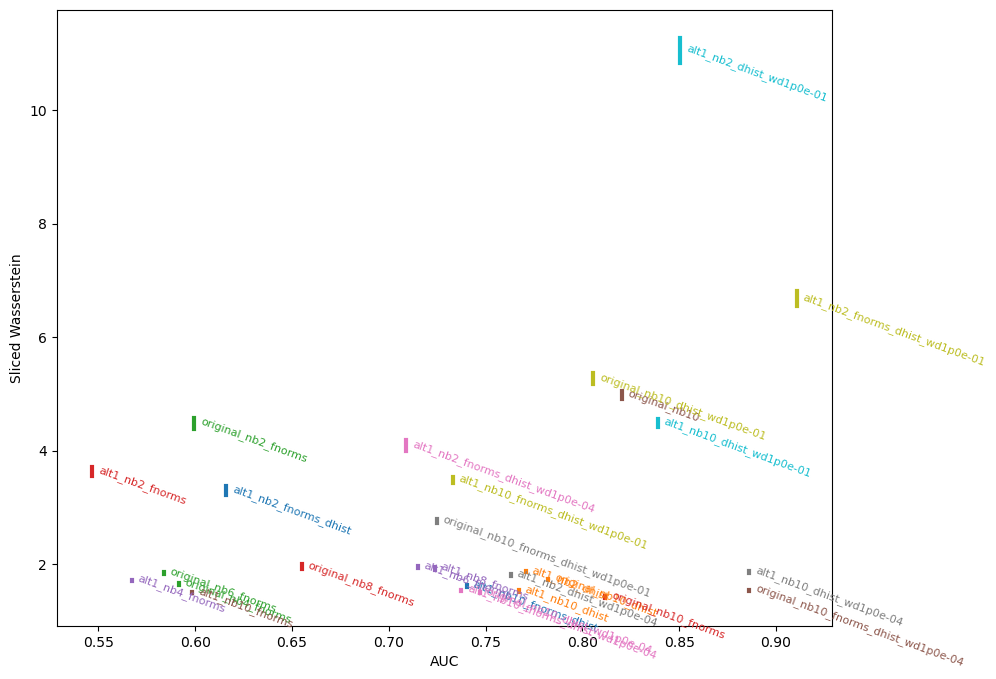

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.cm.tab10
heights = np.linspace(np.min(distances), np.max(distances), n_working)
from sklearn import metrics

for i, w in enumerate(working):
    print(f"{i/n_working}", end="\r")
    name = existing_models["names"][w].split("_wo")[0]
    if name == "original_nb10_fnorms_dhist":
        continue
    distance = np.mean(distances[i])
    distance_err = np.std(distances[i])                
    auc = aucs[w]
    if auc is None:
        continue
    c = cmap(i/n_working)
    plt.text(auc+0.003, distance, name,
             rotation=-20, rotation_mode='anchor',
             color=c, size=8
            )
    n_blocks = existing_models["num_blocks"][w]
    plt.plot([auc, auc], [distance-distance_err, distance+distance_err], lw=3,
             c=c)

plt.ylabel("Sliced Wasserstein")
plt.xlabel("AUC")
plt.savefig("sliced_wasserstein_vs_AUC.png")

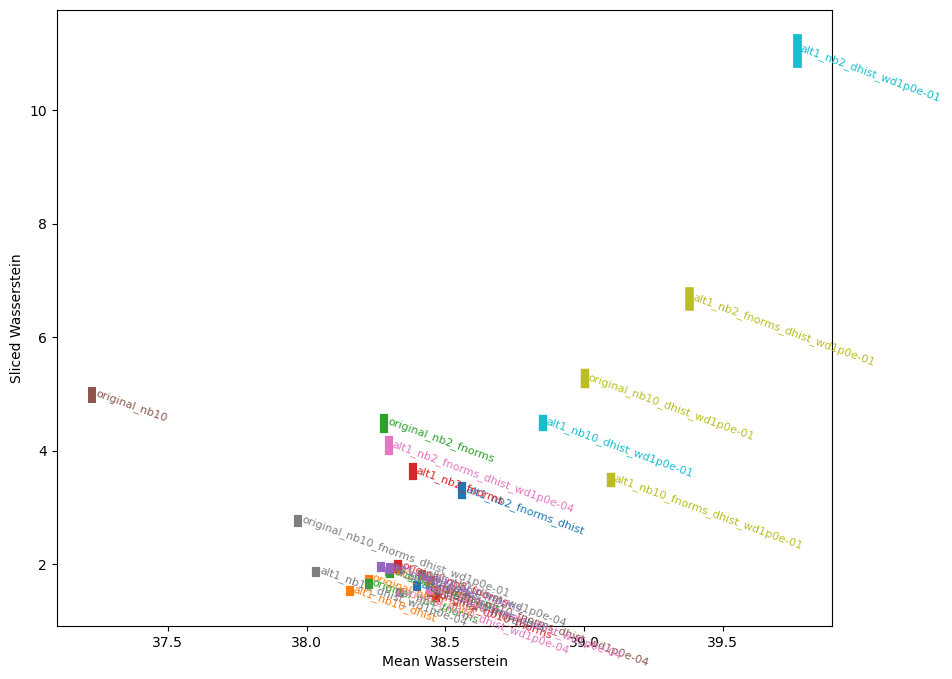

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.cm.tab10
heights = np.linspace(np.min(distances), np.max(distances), n_working)
from sklearn import metrics

for i, w in enumerate(working):
    print(f"{i/n_working}", end="\r")
    name = existing_models["names"][w].split("_wo")[0]
    if name == "original_nb10_fnorms_dhist":
        continue
    distance = np.mean(distances[i])
    distance_err = np.std(distances[i])                
    mean_dis = np.mean(distances_1d[w])            
    std_dis = np.std(distances_1d[w])/10
    c = cmap(i/n_working)
    plt.text(mean_dis+0.01, distance, name,
             rotation=-20, rotation_mode='anchor',
             color=c, size=8
            )
    n_blocks = existing_models["num_blocks"][w]
    plt.plot([mean_dis, mean_dis], [distance-distance_err, distance+distance_err], lw=std_dis,
             c=c)

plt.ylabel("Sliced Wasserstein")
plt.xlabel("Mean Wasserstein")
plt.savefig("wasserstein_comparison.png")

In [59]:
lowest_loss = []
sliced = []
mean = []
fnorms = []
n_blocks = []
aaucs = []

for i, w in enumerate(working):
    print(f"{i/n_working}", end="\r")
    name = existing_models["names"][w].split("_wo")[0]
    if name == "original_nb10_fnorms_dhist":
        continue
    fnorms.append("fnorm" in name)
    n_blocks.append(existing_models["num_blocks"][w])
    lowest_loss.append(existing_models["best_loss"][w])
    sliced.append(np.mean(distances[i]))          
    mean.append(np.mean(distances_1d[w]))  
    aaucs.append(aucs[w])

print()
print(len(lowest_loss))
print(len(aaucs))
lowest_loss = np.array(lowest_loss)
sliced = np.array(sliced)
mean = np.array(mean)
aaucs = np.array(aaucs)
n_blocks = np.array(n_blocks)
fnorms = np.array(fnorms)

0.965517241379310465
28
28


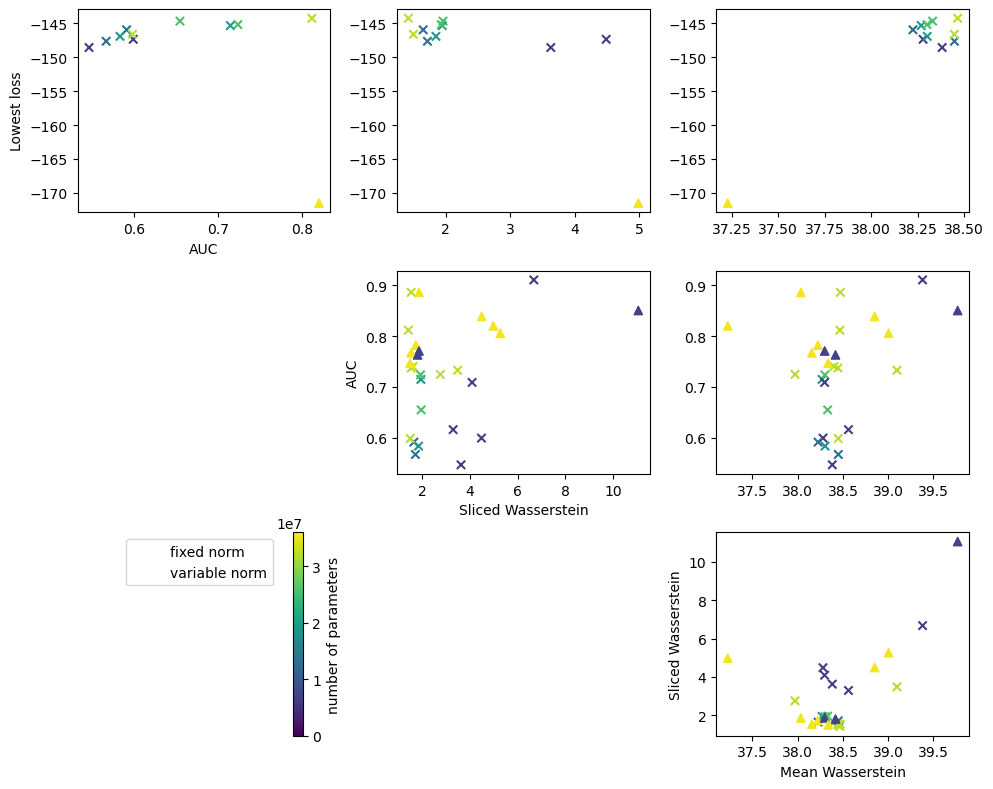

In [88]:
fig, axarr = plt.subplots(3, 3, figsize=(10, 8))#, sharex='col', sharey='row')
cmap = plt.cm.tab10
heights = np.linspace(np.min(distances), np.max(distances), n_working)
from sklearn import metrics
from pointcloud.utils.plotting import blank_axes

blank_axes(axarr[1, 0])
blank_axes(axarr[2, 0])
blank_axes(axarr[2, 1])

def plt_ax(ax, xs, ys, cs, shape, **kwargs):
    thing = ax.scatter(xs[shape], ys[shape], c=cs[shape], marker="x", label="fixed norm", vmin=0, vmax=3.6e7, **kwargs)
    ax.scatter(xs[~shape], ys[~shape], c=cs[~shape], marker="^", label="variable norm", vmin=0, vmax=3.6e7, **kwargs)
    return thing

plt_ax(axarr[2,2], mean, sliced, params[filter_xs], fnorms)
plt_ax(axarr[1,2], mean, aaucs, params[filter_xs], fnorms)
plt_ax(axarr[0,2], mean, lowest_loss, params[filter_xs], fnorms)
axarr[2, 2].set_ylabel("Sliced Wasserstein")
axarr[2, 2].set_xlabel("Mean Wasserstein")
plt_ax(axarr[1, 1], sliced, aaucs, params[filter_xs], fnorms)
plt_ax(axarr[0, 1], sliced, lowest_loss, params[filter_xs], fnorms)
axarr[1, 1].set_xlabel("Sliced Wasserstein")
axarr[1, 1].set_ylabel("AUC")
thing = plt_ax(axarr[0, 0], aaucs, lowest_loss, params[filter_xs], fnorms)
axarr[0, 0].set_xlabel("AUC")
axarr[0, 0].set_ylabel("Lowest loss")

plt.colorbar(thing, ax=axarr[2, 0], label="number of parameters")
hs, ls = axarr[0, 0].get_legend_handles_labels()
axarr[2, 0].legend(hs, ls)

for ix, iy in ((0, 0), (1, 1), (2, 2)):
    axarr[ix, iy].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True) # labels along the bottom edge are off
    axarr[ix, iy].tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=True) # labels along the bottom edge are off
    
plt.tight_layout()
plt.savefig("multi_comparison2.png")
plt.savefig("multi_comparison2.pdf")

In [38]:

def plt_ax(xs, ys, cs, shape, x_name, y_name, **kwargs):
    fig, ax = plt.subplots()
    thing = ax.scatter(xs[shape], ys[shape], c=cs[shape], marker="x", label="fixed norm", vmin=1, vmax=10, **kwargs)
    ax.scatter(xs[~shape], ys[~shape], c=cs[~shape], marker="^", label="variable norm", vmin=1, vmax=10, **kwargs)
    plt.colorbar(thing, label="number of blocks")
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{x_name}_{y_name}.png")
    plt.savefig(f"{x_name}_{y_name}.pdf")
    plt.close()
    return thing

plt_ax(mean, sliced, n_blocks, fnorms, "Mean Wasserstein", "Sliced Wasserstein")
plt_ax(mean, aaucs, n_blocks, fnorms, "AUC", "Lowest loss")
plt_ax(mean, lowest_loss, n_blocks, fnorms, "Mean Wasserstein", "Lowest loss")
plt_ax(sliced, aaucs, n_blocks, fnorms, "Sliced Wasserstein", "AUC")
plt_ax(sliced, lowest_loss, n_blocks, fnorms, "Sliced Wasserstein", "Lowest loss")
thing = plt_ax(aaucs, lowest_loss, n_blocks, fnorms, "AUC", "Lowest loss")


In [39]:
params = np.zeros(len(working))

for i, w in enumerate(working):
    print(f"{i/len(working)}", end='\r')
    path = existing_models["paths"][w]
    loaded = torch.load(path, map_location='cpu')['model']
    stack = [loaded[k] for k in loaded.keys()]
    unknown = []
    while stack:
        thing = stack.pop()
        if hasattr(thing, 'keys'):
            for k in thing.keys():
                stack.append(thing[k])
        elif isinstance(thing, torch.Tensor):
            params[i] += np.prod(thing.size())
        else:
            unknown.append(thing)

    if unknown:
        print("couldn't parse some things;")
        print(unknown)
        print()

print(params)



[32166220.  6433244. 32166220. 35360710.  7072142. 35360710.  6433244.
 12866488. 19299732. 25732976. 32166220.  6433244. 12866488. 19299732.
 25732976. 32166220. 35360710. 32166220.  6433244. 32166220. 35360710.
  7072142. 35360710. 32166220.  6433244. 32166220. 35360710.  7072142.
 35360710.]


28


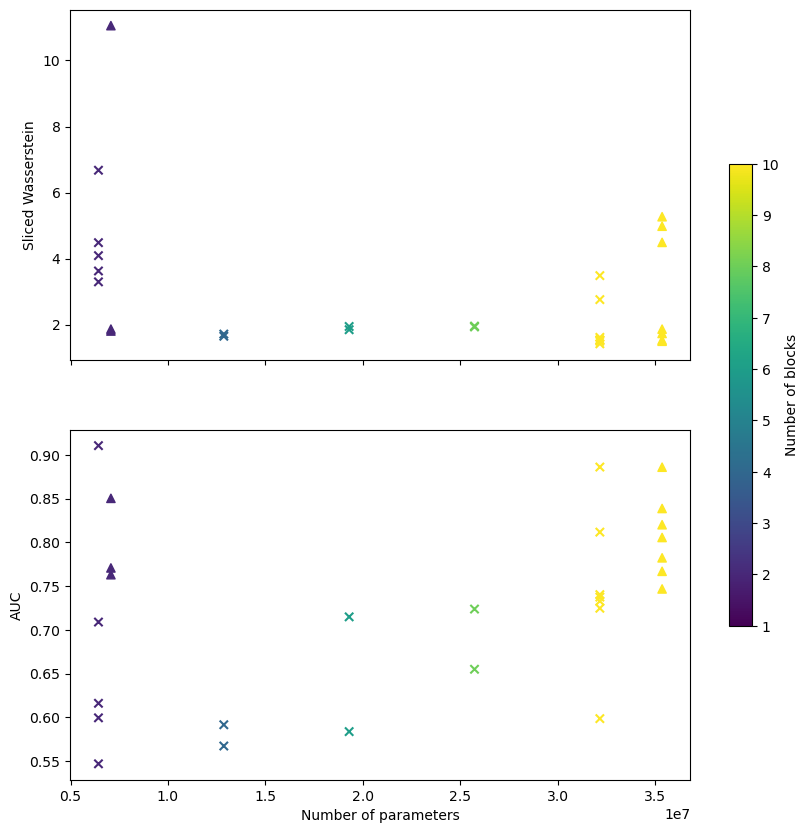

In [47]:

filter_xs = [existing_models["names"][w].split("_wo")[0]!="original_nb10_fnorms_dhist" for w in working]
print(np.sum(filter_xs))
def plt_subax(ax, xs, ys, cs, shape, x_name, y_name, **kwargs):
    xs = xs[filter_xs]
    thing = ax.scatter(xs[shape], ys[shape], c=cs[shape], marker="x", label="fixed norm", vmin=1, vmax=10, **kwargs)
    ax.scatter(xs[~shape], ys[~shape], c=cs[~shape], marker="^", label="variable norm", vmin=1, vmax=10, **kwargs)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    return thing
fig, axarr = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

plt_subax(axarr[0], params, sliced, n_blocks, fnorms, "", "Sliced Wasserstein")
thing = plt_subax(axarr[1], params, aaucs, n_blocks, fnorms, "Number of parameters", "AUC")

fig.colorbar(thing, ax=axarr, shrink=0.6, label="Number of blocks")
plt.savefig("number_of_params_vs_performance.png")
plt.savefig("number_of_params_vs_performance.pdf")


28


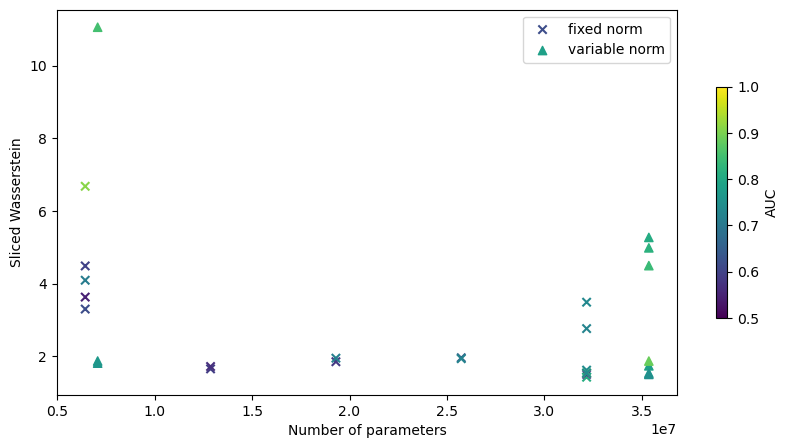

In [82]:

filter_xs = [existing_models["names"][w].split("_wo")[0]!="original_nb10_fnorms_dhist" for w in working]
print(np.sum(filter_xs))
def plt_subax(ax, xs, ys, cs, shape, x_name, y_name, **kwargs):
    xs = xs[filter_xs]
    thing = ax.scatter(xs[shape], ys[shape], c=cs[shape], marker="x", label="fixed norm", vmin=0.5, vmax=1, **kwargs)
    ax.scatter(xs[~shape], ys[~shape], c=cs[~shape], marker="^", label="variable norm", vmin=0.5, vmax=1, **kwargs)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    return thing
fig, axarr = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

thing = plt_subax(axarr, params, sliced, aaucs, fnorms, "Number of parameters", "Sliced Wasserstein")
#thing = plt_subax(axarr[1], params, aaucs, n_blocks, fnorms, "Number of parameters", "AUC")

fig.colorbar(thing, ax=axarr, shrink=0.6, label="AUC")
plt.savefig("number_of_params_vs_performance2.png")
plt.savefig("number_of_params_vs_performance2.pdf")
plt.legend()


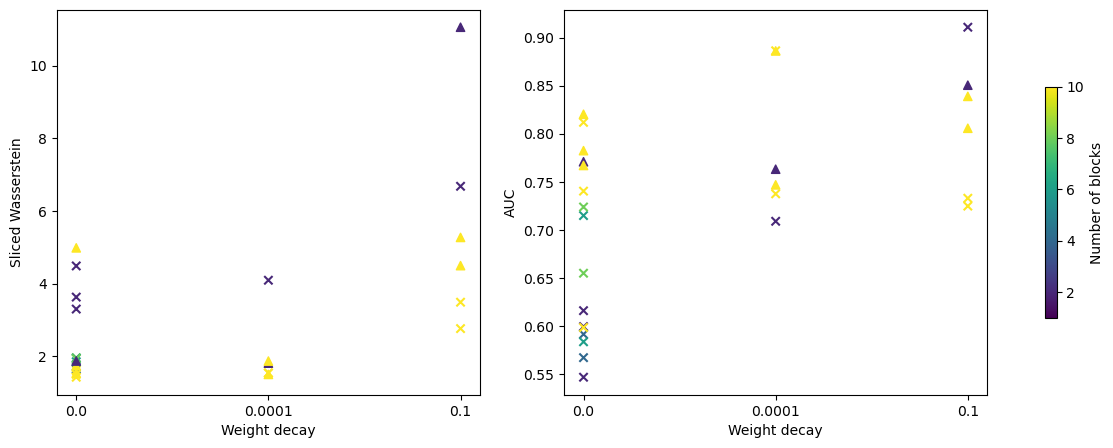

In [86]:
def plt_subax(ax, xs, ys, cs, shape, x_name, y_name, **kwargs):
    xs = xs[filter_xs]
    unique_xs = np.unique(xs)
    x_dict = {x:i for i, x in enumerate(unique_xs)}
    for x in x_dict:
        matches = xs == x
        ys_here = ys[shape&matches]
        xs_here = np.full_like(ys_here, x_dict[x])
        thing = ax.scatter(xs_here, ys_here, c=cs[shape&matches], marker="x", label="fixed norm", vmin=1, vmax=10, **kwargs)
        ys_here = ys[(~shape)&matches]
        xs_here = np.full_like(ys_here, x_dict[x])
        ax.scatter(xs_here, ys_here, c=cs[(~shape)&matches], marker="^", label="variable norm", vmin=1, vmax=10, **kwargs)
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
    ax.set_xticks(list(range(len(unique_xs))), unique_xs)
    return thing
fig, axarr = plt.subplots(1, 2, figsize=(15, 5), sharex=True)


weight_decays = np.array(existing_models["weight_decay"])[working]
plt_subax(axarr[0], weight_decays, sliced, n_blocks, fnorms, "Weight decay", "Sliced Wasserstein")
thing = plt_subax(axarr[1], weight_decays, aaucs, n_blocks, fnorms, "Weight decay", "AUC")

fig.colorbar(thing, ax=axarr, shrink=0.6, label="Number of blocks")
plt.savefig("weight_decay_vs_performance.png")
plt.savefig("weight_decay_vs_performance.pdf")


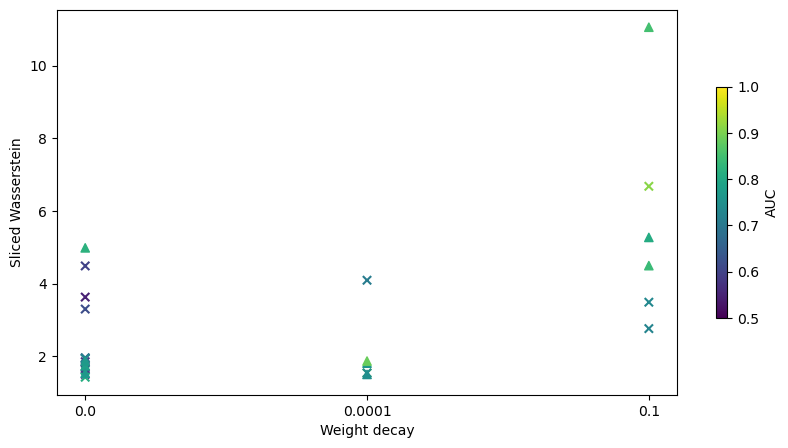

In [85]:
def plt_subax(ax, xs, ys, cs, shape, x_name, y_name, **kwargs):
    xs = xs[filter_xs]
    unique_xs = np.unique(xs)
    x_dict = {x:i for i, x in enumerate(unique_xs)}
    for x in x_dict:
        matches = xs == x
        ys_here = ys[shape&matches]
        xs_here = np.full_like(ys_here, x_dict[x])
        thing = ax.scatter(xs_here, ys_here, c=cs[shape&matches], marker="x", label="fixed norm", vmin=0.5, vmax=1, **kwargs)
        ys_here = ys[(~shape)&matches]
        xs_here = np.full_like(ys_here, x_dict[x])
        ax.scatter(xs_here, ys_here, c=cs[(~shape)&matches], marker="^", label="variable norm", vmin=0.5, vmax=1, **kwargs)
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
    ax.set_xticks(list(range(len(unique_xs))), unique_xs)
    return thing
fig, axarr = plt.subplots(1, 1, figsize=(10, 5), sharex=True)


weight_decays = np.array(existing_models["weight_decay"])[working]
thing = plt_subax(axarr, weight_decays, sliced, aaucs, fnorms, "Weight decay", "Sliced Wasserstein")
#thing = plt_subax(axarr[1], weight_decays, aaucs, n_blocks, fnorms, "Weight decay", "AUC")

fig.colorbar(thing, ax=axarr, shrink=0.6, label="AUC")
plt.savefig("weight_decay_vs_performance2.png")
plt.savefig("weight_decay_vs_performance2.pdf")


In [54]:
existing_models.keys()

dict_keys(['versions', 'names', 'num_blocks', 'cut_inputs', 'best_loss', 'paths', 'cond_features', 'weight_decay', 'fixed_input_norms', 'config', 'Wasserstein_distances', 'sliced_wasserstein_distances'])

In [48]:
for k in existing_models:
    print(f"{k} {len(existing_models[k])}")

versions 32
names 32
num_blocks 32
cut_inputs 32
best_loss 32
paths 32
cond_features 32
weight_decay 32
fixed_input_norms 32
config 32
Wasserstein_distances 32
sliced_wasserstein_distances 29


In [49]:
from pointcloud.models import shower_flow
from pointcloud.utils import showerflow_utils
from pointcloud.data.conditioning import get_cond_dim

def get_loaded_flow(i):
    constructor = shower_flow.versions_dict[existing_models['versions'][i]]
    config_here = existing_models['config'][i]
    num_inputs = np.sum(showerflow_utils.get_input_mask(config_here))
    num_cond = get_cond_dim("showerflow", config_here)
    model, flow_dist, transforms = constructor(config_here.shower_flow_num_blocks, num_inputs, num_cond, 'cpu')
    return flow_dist, num_cond
    
flow, inputs = get_loaded_flow(0)
condit = flow.condition(torch.zeros(inputs))
condit.sample()

tensor([ 1.0137,  0.0067,  0.2536, -1.5169,  0.7592, -3.1792, -0.2419,  0.8283,
         1.4115, -0.2834,  0.4310,  0.0222, -1.1749, -1.1007, -1.1836, -0.6029,
        -0.1109,  0.1055,  0.5557, -0.9077, -2.1432,  0.4027, -0.8705, -0.4834,
        -0.4993,  1.1457, -0.3367, -0.7032,  0.6228, -0.4841,  1.4602,  1.1267,
         0.5058, -1.3325,  0.4323, -1.8281, -2.3629,  0.4138,  0.3689, -1.8805,
        -0.2603, -1.2316,  2.0244,  0.9813, -0.4012,  0.6668, -1.1430,  0.3523,
         0.1783, -1.6787, -0.3541,  2.1624,  0.5256, -0.4940, -0.8944,  0.9790,
        -0.1661, -0.8772, -1.7896,  0.1013,  1.5474,  0.2600])